# Info 6010 Ex 1
### 3 Feb 2019, covers lectures 2,3, due Thu night 13 Feb 2019

[You should start with a new empty notebook, call it s1, and copy/paste only code that you need from cells in this notebook, the full problem statements are not necessary.<br>
The first cell at the top should include your name, netid, and 'Ex1': use the menu button 2nd from right to change from code to markdown cell.]<br>
Upload to usual course [upload site](https://pgcourse.infosci.cornell.edu/cgi-bin/probset.py).

This covers some simple text manipulation, to give a better handle on where everyone stands.

The first part illustrates basic file manipulations, and other things from [lec2](https://piazza.com/class/k5vlbhuxrhq4oa?cid=9), including the Shakespeare power law (cell [29] of [lec2a.ipynb](http://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/lec2a.ipynb)).

The latter part applies the simple "Naive Bayes" methodology (to be continued in lec3) to construct a simple text classifier. (This is really a warmup, certainly  too elementary for some, but at the edge of feasibility for others so the text provides most of the framework, conveying the basic "test set / training set" machine learning methodology.
There's an extra problem for students with prior [scikit-learn.org](https://scikit-learn.org/stable/) experience.)

## Data


An example used in [lec2b.ipynb](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/lec2b.ipynb) involved building a Bernoulli Naive Bayes classifier based on 1000 abstracts each from a single physics category and a single biology category (1800 training texts, and 200 test texts). This dataset [Ex1data.py.gz](https://www.cs.cornell.edu/~ginsparg/6010/spr20/Ex1data.py.gz) expands on that with similar data from twelve categories. gunzip that file and use

    from Ex1data import absdata

to import absdata, which will then be a dictionary of twelve subject areas in fields of astrophysics (GA = galaxies), condensed matter, computer science (CV= computer vision, HC = human computer interactions, LG = machine learning), two closely related areas of high energy physics (phenomenology and theory), math, applied physics, computational physics, biology (NC= neurons and cognition), and quantum physics. The value of each is a list of the texts of 1000 recent abstracts, for a total of 12000 abstracts.

In [1]:
from Ex1data import absdata
print (sorted(absdata))

['astro-ph.GA', 'cond-mat.mes-hall', 'cs.CV', 'cs.HC', 'cs.LG', 'hep-ph', 'hep-th', 'math.AP', 'physics.app-ph', 'physics.comp-ph', 'q-bio.NC', 'quant-ph']


In [2]:
print ([len(absdata[cat]) for cat in absdata])  #cat = "category"

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [3]:
#first cs.HC abstract
absdata['cs.HC'][0]

'Data-driven decision making related to individuals has become increasingly pervasive, but the issue concerning the potential discrimination has been raised by recent studies. In response, researchers have made efforts to propose and implement fairness measures and algorithms, but those efforts have not been translated to the real-world practice of data-driven decision making. As such, there is still an urgent need to create a viable tool to facilitate fair decision making. We propose FairSight, a visual analytic system to address this need; it is designed to achieve different notions of fairness in ranking decisions through identifying the required actions -- understanding, measuring, diagnosing and mitigating biases -- that together lead to fairer decision making. Through a case study and user study, we demonstrate that the proposed visual analytic and diagnostic modules in the system are effective in understanding the fairness-aware decision pipeline and obtaining more fair outcomes

As discussed for the Shakespeare case in lec2, it's necessary to tokenize, or split the texts into something like words. There for simplicity the text was split on whitespace using the `.split()` method, but that left punctuation characters.
For a more useful spliting, words can be considered strings of lower case letters a-z plus apostrophes, and extracted as a list. For example, for the first cs.HC text above, and using a regular expression that finds all strings with a-z and ':

In [ ]:
import re
re.findall("[a-z0-9']+", absdata['cs.HC'][0].lower())

(`re.findall("[a-z0-9']+",txt)` just finds all contiguous strings made up of the characters a-z or digits 0-9 or apostrophe ', and returns them as a list.)

This will return a list of all the 'words' in that document (try it). For the time being, we only want to count the *number of documents* in which a word occurs (not the number of *occurrences* within the document), so we apply `set()` to the above list so that each word only appears once.
Finally, it's convenient to use the Counter object (http://docs.python.org/2/library/collections.html), which is just a dictionary to accumulate counts for the words. The result is (try it):

In [ ]:
from collections import Counter
Counter( re.findall("[a-z0-9']+", absdata['cs.HC'][0].lower()) ).most_common(20)
# 20 most common, 'the' should appear 7 times

In [4]:
#setup for inline plotting
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

## 1) Zipf's Law

Start with a look at word distributions and power laws. The following cell iterates through the 2000 abstracts from cs.HC and cs.LG, and accumulates their word counts in the Counter object `thewords`:

In [5]:
from collections import Counter
import re

thewords=Counter()
for subj in ('cs.HC', 'cs.LG'):
    for txt in absdata[subj]:
       thewords += Counter( re.findall("[a-z0-9']+", txt.lower()) )

In [6]:
#size of vocab
len(thewords)

13861

You can look at the top few words and their counts, using say (try it...)

    thewords.most_common(40)

(the most common word should be 'the', and it should occur more than 15000 times).
`thewords` is a python dictionary (with some extra methods), so the counts themselves are contained in `thewords.values()`, use `sum(thewords.values())` on those to determine the total number of words in the "corpus" (It should be over 300,000.)

The object of the part of the assignment is to plot the number of occurrences for the top 10000 words in your `thewords` dictionary on the y-axis, ordered so that the word with the largest number of occurrences is plotted first, the word with second largest number of occurrences is plotted second, and so on. This is known as a "rank-frequency" graph, since it plots the frequency of occurrence vs. the rank of the word.

The first graph you plot might look something like cell [28] of [lec2a.ipynb](http://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/lec2a.ipynb), with some words used very frequently, and most used less frequently. It's difficult to see the overall structure of the data in that cell since most of the values are so small. A standard method is to plot using logarithmic scales as in cell [29], so that a fixed distance along the axis corresponds to say a factor of 10 (rather than just adding 10). This can be implemented by adding `plt.xscale('log')` or `plt.yscale('log')`, or both, before or after the `plt.plot()` command; or by using `plt.loglog()` instead of `plt.plot()` (or `plt.semilogx()` or `plt.semilogy()` for only one or the other axis). They give the same type of plot.

Your second plot should look something like this (except use real data, rather than the synthetic data used here, so it won't "magically" follow a straight line in log-log coordinates -- for this "data" automatic since it was generated artificially using the function 1/r for rank r):

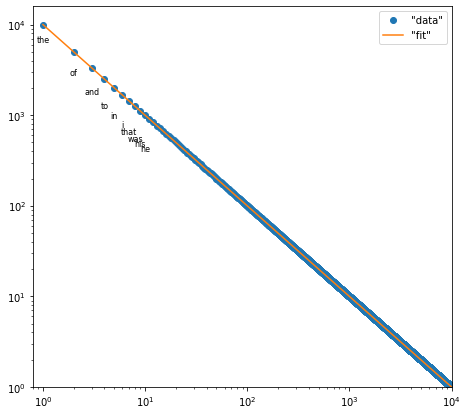

In [18]:
m=10000.
#fake top10 (instead use the real top10):
top10 = ['the', 'of', 'and', 'to', 'in', 'i', 'that', 'was', 'his', 'he']

plt.figure(figsize=(7.5,7))
r = 1+np.arange(10000)
plt.loglog(r,m/r,'o') #fake data, use instead real data
plt.xlim(.8,1e4)
plt.ylim(1,)
plt.plot(r,m/r,'-') #fake "fit" to data
for x,y,w in zip(r,m/r,top10):
    plt.text(x,.1*y**1.2,w,ha='center', fontsize=8)
plt.legend(['"data"','"fit"']);

The figure above also uses the `plt.text()` command to label the top ten occurring words (where that top ten is not from the cs.HC/cs.LG data, but instead data for the [Gutenberg corpus](http://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/PG/2006/04/1-10000) ).
Also plotted in orange is a "fit" to the data, where the fit in this case is exact since it's just the same 1/r function used to generate the data.

**A.** The above is idealized data, the object of this problem is to see what the plot looks like for real data.

For this part of the assignment, you should figure out how to extract the counts for the top 10000 words in your `thewords` dictionary, and plot those counts against the word ranks. You should annotate the top ten words on the graph with what they are (as above, though using the actual word rank in your dictionary).
Finally you should try to fit the data you've plotted with a straight line, as above. (You can do this visually, by experimenting with values of `m`, or if more ambitious you can use a linear regression `scipy.stats.linregress()` to find the best straight line: by running `linregress()` on the `np.log()` of the x-values and y-values to determine the slope `a` and intercept `b` in log-log space, then plotting `np.exp(a*x+b)` which will render as a straight line. If you do the latter, just fit to the words ranked 7th through 3000th to avoid noisy data at the two ends.)

Not to give too much of a spoiler, you should find that many of the data points do fall roughly along a straight line in log-log space (Zipf's law), even for this small amount of data (i.e., only the 2000 short abstracts).<br>
(Feel free to try it for all 12000 abstracts, just change `for subj in ('cs.HC', 'cs.LG'):` in the above code to `for subj in absdata:` to iterate over all twelve.)

**B.** Regarding the Oxford English Corpus (=OEC, more than 2 billion words), it says
[here](https://en.wikipedia.org/wiki/Most_common_words_in_English): "the first 25 words in the OEC make up about one-third of all printed material in English, and the first 100 words make up about half of all written English".<br>
For the corpus in this problem, `sum(thewords.values())` gives the total number of words (i.e., words counted with their multiplicities), and `len(thewords)` gives the number of *distinct* words (i.e., the size of the vocabulary).<br>
*i)* What percentage of the corpus is made up of the top 10, top 25, and of the top 100 ranked words?<br>
*ii)* For this corpus, what number of top ranked words make up 25%, 50%, 75% of the corpus?<br>
*iii)* For each of the numbers in ii), what percentage of the vocabulary do they represent?<br>
(e.g., if the top 100 words in a vocabulary of 10000 distinct words were used 50000 times in a corpus of size 100000 words, then that would mean the top ranked 1% of words constitutes 50% of the corpus)

## 2) Naive Bayes text classifier

Here you will train a simple binary classifier, for cs.HC = Human computer interactions vs. cs.LG = machine learning, based on the first 900 abstracts in each of those two categories, and test it on the last 100 "test" abstracts from each category. This follows the example given in [lec2b.ipynb](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/lec2b.ipynb).

Parts of the remainder of this notebook are useful only if it isn't clear how to proceed (and you're free to deviate in any way you want).

For variety, now we'll count only the *number of documents* in which a word occurs (not the number of *occurrences* within the document). To this end, we apply set() to the list of words so that each word only appears once.
Again using the `Counter()` object (http://docs.python.org/2/library/collections.html), the result of inserting `set()` is (try it):

In [ ]:
Counter(set(re.findall("[a-z0-9']+",absdata['cs.HC'][0].lower())))

The number counts (number of documents in which word occurs) can be accumulated as was done for bvocab and pvocab in cell [10] of [lec2b.ipynb](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/lec2b.ipynb), perhaps call them `HCvocab` and `LGvocab`.

Again using the `Counter()` object's convenient `most_common` method, you can look at the numbers for the most frequent words (where 900 would mean they occurred in all 900 training documents):

In [ ]:
Counter(HCvocab).most_common(10)

or to see the 285th through 296th, use (try it, should give words appearing in only forty eight of the training documents):

In [ ]:
Counter(HCvocab).most_common()[285:296]

---
**B.** As mentioned above, there are 10000 more abstracts in the Ex1data.py (for a total of 12 classes).

Implement a four way classifier (cs.HC, cs.LG, cs.CV = computer vision, q-bio.NC = neurons and cognition), where for example the probability of cs.HC would now be:
$$p({\rm HC}\ |\ words) = \frac{p(words\ |\ {\rm HC})\,p({\rm HC})}{p(words\ |\ {\rm HC})\,p({\rm HC}) + p(words\ |\ {\rm LG})\,p({\rm LG}) + p(words\ |\ {\rm CV})\,p({\rm CV}) + p(words\ |\ {\rm NC})\,p({\rm NC})} \approx \frac{\prod_i p(w_i\ |\ {\rm HC})}{\prod_i p(w_i\ |\ {\rm HC}) + \prod_i p(w_i\ |\ {\rm LG}) + \prod_i p(w_i\ |\ {\rm CV}) + \prod_i p(w_i\ |\ {\rm NC})}$$
<br>
and similarly for cs.LG, cs.CV, and q-bio.NC. The predicted classification is the one with the highest probability.

Train it on the first 900 abstracts in each of those four categories (a total of 3600 documents), and test on the last 100 from each of those four categories (a total of 400 documents).

---
**C. (optional)** Implement a twelve way classifier (all twelve classes in cell [1] above), 
trained on the first 900 abstracts in each of the categories (a total of 10800 documents), and test on the last 100 from each of those four categories (a total of 1200 documents). In class we'll consider metrics to disentangle the performance on multiple classes (using [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html),
[confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), or
[plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html)).


---
**D. (really optional)** If you're already familiar with scikit-learn data formats, then it's instructive (and very quick) to redo the above using either [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) (i.e., True/False whether or not word is in document as above), or 
[Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
(using the number counts within documents).


## 3. Bayes' Rule

In [lec3.pdf](https://www.cs.cornell.edu/~ginsparg/6010/spr20/lec3.pdf), we saw three examples of Bayes' rule. Here are three simple follow-up questions to reinforce understanding, and form more experience making simple plots.

### A. "occasionally dishonest casino"
We discussed the "occasionally dishonest casino" that used two
kinds of dice: 99% were fair ($F$), but 1% were loaded ($L$) such that a 6 came up 50%
of the time. Thus $p(L)=1/100$, and the conditional probabilities are
$p(6\,|\,L)=1/2$ and $p(6\,|\,F)=1/6$. If we select a die at random and roll three 6's in a row, we saw that the posterior probability $p(L\,|\,6^3)$ that it was loaded was only 3/14.

**a)**  How many sixes in a row would we have to roll before concluding it
was more likely ($>50\%$ probability) to have been a loaded die?

**b)** In your notebook, plot a graph of $p(L\,|\, 6^n)$ for $n$ ranging from 0 to 9. (remember to label the axes, and to give it a title)

**c)** Suppose that the loaded die has instead $p(6|L)=1/3$, but with $p(L)=.1$ (only 90% of the dice now fair). What would $p(L\,|\,6^3)$ be in this case?  Add a plot for the new $p(L\,|\, 6^n)$ to the same graph as in part b).

### B. Duchenne Muscular Dystrophy
We also discussed Duchenne Muscular Dystrophy (DMD),
regarded as a simple recessive sex-linked disease caused by a mutated X chromosome (X&#771;).
An X&#771;Y male expresses disease, whereas an X&#771;X female is a carrier but does not
express the disease. If neither of a woman's parents expresses the disease, but
her brother does, then the woman's mother must be a carrier, and the woman
herself has an *a priori* 50/50 chance of being a carrier, $p(C)=1/2$.
We saw that if she has had a single healthy son, then her probability of being a
carrier drops to $p(C\,|\,1 {\rm h.s.})=1/3$.

**a)** What is the woman's probability $p(C\,|\,n\ {\rm h.s.})$ of being a carrier if she gives birth to $n$ healthy sons ($n$ h.s.)?

**b)** For how many healthy sons does her probability of being a carrier fall below 1%?

**c)** In your notebook, plot a graph of $p(C\,|\,n\ {\rm h.s.})$ for $n$ from 0 to 9. (remember to label the axes, and to give it a title)


### C. Lie detector
We discussed briefly (with more detail in lec3 slids) the case of the probability of having a rare disease given a positive test result. A similar question involves the administration of lie detector tests at a hypothetical national laboratory (where the course instructor was formerly employed).
We can generously assume that these tests have a 85% sensitivity, i.e., the probability of a spy failing the test is $p(f\,|\,S)=.85$, and equally generously can assume that the tests have a false positive rate of only 25%, i.e., the probability of a non-spy failing the test is $p(f\,|\,\overline S)=.25$. We assume that roughly one in ten thousand laboratory employees is a spy, $p(S)=10^{-4}$.

**a)** What is the probability $p(S\,|\,f)$ that someone who has failed the test is a spy?

**b)** Although current empirical data suggests $p(f\,|\,S)=0$ (all known spies have been discovered by other means, and regularly passed lie detector tests), let's assume the opposite extreme, that $p(f\,|\,S)=1$, i.e., the test is 100% sensitive.
How does that affect the result of part a)?